In [7]:
pip install cirq

     |████████████████████████████████| 1.4MB 3.5MB/s 
     |████████████████████████████████| 1.2MB 18.2MB/s 
  Found existing installation: protobuf 3.10.0
    Uninstalling protobuf-3.10.0:
      Successfully uninstalled protobuf-3.10.0


In [0]:
import cirq
import math
import numpy as np
import matplotlib.pyplot as plt
from cirq import GridQubit, X, CNOT, TOFFOLI, ry
early = cirq.InsertStrategy.EARLIEST
new = cirq.InsertStrategy.NEW_THEN_INLINE

helper for testing


In [0]:
def flatten(l):
    """
    :param l: nested list of qubits in order given by fullReg
    :return: return list of qubits in order of registers as given in qubit dictionary and from MSB to LSB.
    This used to determine the order of qubits to display in the simulations results
    For a qubit order [a,b], cirq will output in the form (sum |ab>)
    """
    flatList = []
    for i in l:
        if isinstance(i, list):
            flatList.extend(flatten(i))
        else:
            flatList.append(i)
    return flatList

**Create Circuit**

In [0]:
# Define splitting functions and sudakov factors

def P_f(t, g):
    alpha = g**2 * Phat_f(t)/ (4 * math.pi)
    return alpha

def Phat_f(t):
    return math.log(t)

def Phat_bos(t):
    return math.log(t)

def Delta_f(t, g):
    return math.exp(P_f(t,g))

def P_bos(t, g_a, g_b):
    alpha = g_a**2 * Phat_bos(t)/ (4 * math.pi) + g_b**2 * Phat_bos(t)/ (4 * math.pi)
    return alpha

def Delta_bos(t, g_a, g_b):
    return math.exp(P_bos(t, g_a, g_b))


def populateParameterLists(N, timeStepList, P_aList, P_bList, P_phiList, Delta_aList, Delta_bList, Delta_phiList, g_a,
                           g_b, eps):
    """Populates the 6 lists with correct values for each time step theta"""
    for i in range(N):
        # Compute time steps
        t_up = eps ** ((i) / N)
        t_mid = eps ** ((i + 0.5) / N)
        t_low = eps ** ((i + 1) / N)
        timeStepList.append(t_mid)
        # Compute values for emission matrices   
        Delta_a = Delta_f(t_low, g_a)/ Delta_f(t_up, g_a)
        Delta_b = Delta_f(t_low, g_b) / Delta_f(t_up, g_b)
        Delta_phi = Delta_bos(t_low, g_a, g_b) / Delta_bos(t_up, g_a, g_b)
        P_a, P_b, P_phi = P_f(t_mid, g_a), P_f(t_mid, g_b), P_bos(t_mid, g_a, g_b)

        # Add them to the list
        P_aList.append(P_a)
        P_bList.append(P_b)
        P_phiList.append(P_phi)
        Delta_aList.append(Delta_a)
        Delta_bList.append(Delta_b)
        Delta_phiList.append(Delta_phi)

def allocateQubs(N, n_i, L, pReg, hReg, w_hReg, eReg, wReg, n_aReg, w_aReg, n_bReg, w_bReg, n_phiReg, w_phiReg):
    """method 1: Pro: keeps qubits geometrically close (in rectangle), Con: Ordering is weird so hard to debug"""
    pReg.extend([[GridQubit(i,j) for j in range(3)] for i in range(N+n_i)])
    hReg.extend([[GridQubit(i,j) for j in range(4, 4+L)] for i in range(N)])
    w_hReg.extend([GridQubit(N+n_i,j) for j in range(L-1)])
    eReg.extend([GridQubit(N+n_i,L-1)])
    wReg.extend([GridQubit(N+n_i,j) for j in range(L,L+5)])
    n_phiReg.extend([GridQubit(N+n_i+1,j) for j in range(L)])
    w_phiReg.extend([GridQubit(N+n_i+1,j) for j in range(L,2*L-1)])
    n_aReg.extend([GridQubit(N+n_i+2,j) for j in range(L)])
    w_aReg.extend([GridQubit(N+n_i+2,j) for j in range(L,2*L-1)])
    n_bReg.extend([GridQubit(N+n_i+3,j) for j in range(L)])
    w_bReg.extend([GridQubit(N+n_i+3,j) for j in range(L,2*L-1)])

def intializeParticles(circuit, pReg, initialParticles):
    """ Apply appropriate X gates to ensure that the p register contains all of the initial particles.
        The p registers contains particles in the form of a list [LSB, middle bit, MSB]"""
    for currentParticleIndex in range(len(initialParticles)):
        for particleBit in range(3):
            if initialParticles[currentParticleIndex][particleBit] == 1:
                circuit.append(X(pReg[currentParticleIndex][particleBit]), strategy=early)


def flavorControl(circuit, flavor, control, target, ancilla):
    """Controlled x onto targetQubit if "control" particle is of the correct flavor"""
    if flavor == "phi":
        circuit.append([X(control[1]), X(control[2])], strategy=new)
        circuit.append(TOFFOLI(control[0], control[1], ancilla), strategy=new)
        circuit.append(TOFFOLI(control[2], ancilla, target), strategy=new)
        # undo work
        circuit.append(TOFFOLI(control[0], control[1], ancilla), strategy=new)
        circuit.append([X(control[1]), X(control[2])], strategy=new)
    if flavor == "a":
        circuit.append(X(control[0]), strategy=new)
        circuit.append(TOFFOLI(control[0], control[2], target), strategy=new)
        # undo work
        circuit.append(X(control[0]), strategy=new)
    if flavor == "b":
        circuit.append(TOFFOLI(control[0], control[2], target), strategy=new)


def plus1(circuit, l, countReg, workReg, control, ancilla, level):
    """
    Recursively add 1 to the LSB of a register and carries to all bits, if control == 1
    l: number of qubits in count register
    countReg, workReg: count register and associated work register
    control: control qubit to determine if plus1 should be executed
    ancilla: extra work qubit
    level: current qubit we are operating on, recursively travels from qubit 0 to l-1
    """
    # apply X to LSB
    if level == 0:
        circuit.append(CNOT(control, countReg[0]), strategy=new)
    if level < l - 1:
        # first level uses CNOT instead of TOFFOLI gate
        if level == 0:
            # move all X gates to first step to avoid unnecesarry gates
            circuit.append([X(qubit) for qubit in countReg], strategy=new)
            circuit.append(TOFFOLI(countReg[0], control, workReg[0]), strategy=new)
        else:
            circuit.append(TOFFOLI(countReg[level], workReg[level - 1], ancilla), strategy=new)
            circuit.append(TOFFOLI(ancilla, control, workReg[level]), strategy=new)
            circuit.append(TOFFOLI(countReg[level], workReg[level - 1], ancilla), strategy=new)

        circuit.append(TOFFOLI(workReg[level], control, countReg[level + 1]), strategy=new)
        # recursively call next layer
        plus1(circuit, l, countReg, workReg, control, ancilla, level + 1)
        # undo work qubits (exact opposite of first 7 lines - undoes calculation)
        if level == 0:
            circuit.append(TOFFOLI(countReg[0], control, workReg[0]), strategy=new)
            circuit.append([X(qubit) for qubit in countReg], strategy=new)
        else:
            circuit.append(TOFFOLI(countReg[level], workReg[level - 1], ancilla), strategy=new)
            circuit.append(TOFFOLI(ancilla, control, workReg[level]), strategy=new)
            circuit.append(TOFFOLI(countReg[level], workReg[level - 1], ancilla), strategy=new)

def uCount(circuit, m, n_i, l, pReg, wReg, n_aReg, w_aReg, n_bReg, w_bReg, n_phiReg, w_phiReg):
    """
    Populate the count registers using current particle states.
    Uses wReg[0] as the control and wReg[1] as ancilla qubit for flavorControl and plus1, respectively
    """
    for k in range(n_i+m):
        # bosons
        flavorControl(circuit, "phi", pReg[k], wReg[0], wReg[1])
        plus1(circuit, l, n_phiReg, w_phiReg, wReg[0], wReg[1], 0)
        flavorControl(circuit, "phi", pReg[k], wReg[0], wReg[1])
        # a fermions
        flavorControl(circuit, "a", pReg[k], wReg[0], wReg[1])
        plus1(circuit, l, n_aReg, w_aReg, wReg[0], wReg[1], 0)
        flavorControl(circuit, "a", pReg[k], wReg[0], wReg[1])
        # b fermions
        flavorControl(circuit, "b", pReg[k], wReg[0], wReg[1])
        plus1(circuit, l, n_bReg, w_bReg, wReg[0], wReg[1], 0)
        flavorControl(circuit, "b", pReg[k], wReg[0], wReg[1])

def generateParticleCounts(n_i, m, k):
    """Fill countsList with all combinations of n_phi, n_a, and n_b where each n lies in range [0, n_i+m-k],
    and the sum of all n's lies in range [n_i-k, m+n_i-k], all inclusive
    """
    countsList = []
    for numParticles in range(n_i-k, m+n_i-k+1):
        for numPhi in range(0, n_i+m-k+1):
            for numA in range(0, numParticles-numPhi+1):
                numB = numParticles - numPhi - numA
                countsList.append([numPhi, numA, numB])
    return countsList

def reverse(lst):
    """reverse a list in place"""
    lst.reverse()
    return lst

def intToBinary(l, number):
    """Converts integer to binary list of size l with LSB first and MSB last"""
    numberBinary = [int(x) for x in list('{0:0b}'.format(number))]
    numberBinary = (l - len(numberBinary)) * [0] + numberBinary
    return reverse(numberBinary)


def numberControl(circuit, l, number, countReg, workReg):
    """
    Applies an X to the l-2 (0 indexed) qubit of the work register if count register encodes the inputted number in binary
    returns this l-2 qubit, unless l=1, in which case return the only count register qubit
    DOES NOT CLEAN AFTER ITSELF - USE numberControlT to clean after this operation
    """
    if type(number) == int:
        numberBinary = intToBinary(l, number)
    else:
        numberBinary = number
    circuit.append([X(countReg[i]) for i in range(len(numberBinary)) if numberBinary[i] == 0], strategy=new)
    # first level does not use work qubits as control
    if l > 1:
        circuit.append(TOFFOLI(countReg[0], countReg[1], workReg[0]), strategy=new)
        # subfunction to recursively handle toffoli gates

    def binaryToffolis(level):
        circuit.append(TOFFOLI(countReg[level], workReg[level - 2], workReg[level - 1]), strategy=new)
        if level < l - 1:
            binaryToffolis(level + 1)

    if l > 2:
        binaryToffolis(2)
    # return qubit containing outcome of the operation
    if l == 1:
        return countReg[0]
    else:
        return workReg[l - 2]


def numberControlT(circuit, l, number, countReg, workReg):
    """CLEANS AFTER numberControl operation"""
    if type(number) == int:
        numberBinary = intToBinary(l, number)
    else:
        numberBinary = number

    # subfunction to recursively handle toffoli gates
    def binaryToffolisT(level):
        # circuit.append(TOFFOLI(countReg[level], workReg[level-2], workReg[level-1]), strategy=new)
        if level < l:
            binaryToffolisT(level + 1)
            # undo
            circuit.append(TOFFOLI(countReg[level], workReg[level - 2], workReg[level - 1]), strategy=new)

    if l > 2:
        binaryToffolisT(2)
        # undo
    if l > 1:
        circuit.append(TOFFOLI(countReg[0], countReg[1], workReg[0]), strategy=new)
        # undo
    circuit.append([X(countReg[i]) for i in range(len(numberBinary)) if numberBinary[i] == 0], strategy=new)

def uE(circuit, l, n_i, m, n_phiReg, w_phiReg, n_aReg, w_aReg, n_bReg, w_bReg, wReg, eReg, Delta_phi, Delta_a, Delta_b):
    """Determine if emission occured in current step m"""
    countsList = generateParticleCounts(n_i, m, 0)

    for counts in countsList:
        n_phi, n_a, n_b = counts[0], counts[1], counts[2]
        Delta = Delta_phi**n_phi * Delta_a**n_a * Delta_b**n_b
        phiControlQub= numberControl(circuit, l, n_phi, n_phiReg, w_phiReg)
        aControlQub = numberControl(circuit, l, n_a, n_aReg, w_aReg)
        bControlQub = numberControl(circuit, l, n_b, n_bReg, w_bReg)
        circuit.append(TOFFOLI(phiControlQub, aControlQub, wReg[0]), strategy=new)
        circuit.append(TOFFOLI(bControlQub, wReg[0], wReg[1]), strategy=new)
        circuit.append(ry(2*math.acos(np.sqrt(Delta))).controlled().on(wReg[1], eReg[0]))
        #undo
        circuit.append(TOFFOLI(bControlQub, wReg[0], wReg[1]), strategy=new)
        circuit.append(TOFFOLI(phiControlQub, aControlQub, wReg[0]), strategy=new)
        numberControlT(circuit, l, n_b, n_bReg, w_bReg)
        numberControlT(circuit, l, n_a, n_aReg, w_aReg)
        numberControlT(circuit, l, n_phi, n_phiReg, w_phiReg)


def generateGrayList(l, number):
    """
    l is the size of the current count register
    Return list of elements in gray code from |0> to |number> where each entry is of type[int, binary list].
    int: which bit is the target in the current iteration, binary list: the state of the rest of the qubits (controls)
    """
    grayList = [[0, l * [0]]]
    targetBinary = intToBinary(l, number)
    for index in range(len(targetBinary)):
        if targetBinary[index] == 1:
            grayList.append([index, (list(grayList[-1][1]))])
            grayList[-1][1][index] = 1
    return grayList[1:]


def twoLevelControlledRy(circuit, l, angle, k, externalControl, reg, workReg):
    """
    Implements two level Ry rotation from state |0> to |k>, if externalControl qubit is on
    for reference: http://www.physics.udel.edu/~msafrono/650/Lecture%206.pdf
    """
    grayList = generateGrayList(l, k)
    # handle the case where l=0 or 1
    if k==0:
        return
    if l == 1 and k == 1:
        circuit.append(cirq.ry(angle).controlled().on(externalControl, reg[0]))
        return

    # swap states according to Gray Code until one step before the end
    for element in grayList:
        targetQub = element[0]
        number = element[1]
        number = number[0:targetQub] + number[targetQub + 1:]
        controlQub = numberControl(circuit, l - 1, number, reg[0:targetQub] + reg[targetQub + 1:], workReg)
        if element == grayList[-1]:  # reached end
            circuit.append(TOFFOLI(controlQub, externalControl, workReg[l - 2]), strategy=new)
            circuit.append(cirq.ry(angle).controlled().on(workReg[l - 2], reg[targetQub]))
            circuit.append(TOFFOLI(controlQub, externalControl, workReg[l - 2]), strategy=new)
        else:  # swap states
            circuit.append(CNOT(controlQub, reg[targetQub]), strategy=new)
        numberControlT(circuit, l - 1, number, reg[0:targetQub] + reg[targetQub + 1:], workReg)

    # undo
    for element in reverse(grayList[:-1]):
        targetQub = element[0]
        number = element[1]
        number = number[0:targetQub] + number[targetQub + 1:]
        controlQub = numberControl(circuit, l - 1, number, reg[0:targetQub] + reg[targetQub + 1:], workReg)
        circuit.append(CNOT(controlQub, reg[targetQub]), strategy=new)
        numberControlT(circuit, l - 1, number, reg[0:targetQub] + reg[targetQub + 1:], workReg)
    return

def U_hAngle(flavor, n_phi, n_a, n_b, P_phi, P_a, P_b):
    """Determine angle of rotation used in U_h"""
    denominator = n_phi * P_phi + n_a * P_a + n_b * P_b
    if denominator == 0: # occurs if we are trying the case of no particles remaining (n_a = n_b = n_phi = 0)
        return 0
    flavorStringToP = {'phi': P_phi, 'a': P_a, 'b': P_b}
    emissionAmplitude = np.sqrt(flavorStringToP[flavor] / denominator)
    # correct for arcsin input greater than 1 errors for various input combinations that are irrelevant anyway
    emissionAmplitude = min(1, emissionAmplitude)
    return 2 * np.arcsin(emissionAmplitude)


def minus1(circuit, l, countReg, workReg, control, ancilla, level):
    """
    Recursively carries an subtraction of 1 to the LSB of a register to all bits if control == 1
    Equivalent to plus1 but with an X applied to all count qubits before and after gate
    """
    circuit.append([X(qubit) for qubit in countReg], strategy=new)
    plus1(circuit, l, countReg, workReg, control, ancilla, level)
    circuit.append([X(qubit) for qubit in countReg], strategy=new)


def U_h(circuit, l, n_i, m, n_phiReg, w_phiReg, n_aReg, w_aReg, n_bReg, w_bReg, wReg, eReg, pReg, hReg, w_hReg, P_phi,
        P_a, P_b):
    """Implement U_h from paper"""
    for k in range(n_i + m):
        countsList = generateParticleCounts(n_i, m, k)  # reduce the available number of particles
        for counts in countsList:
            n_phi, n_a, n_b = counts[0], counts[1], counts[2]
            # controlled R-y from |0> to |k> on all qubits with all possible angles depending on n_phi, n_a, n_b, and flavor
            for flavor in ['phi', 'a', 'b']:
                angle = U_hAngle(flavor, n_phi, n_a, n_b, P_phi, P_a, P_b)
                phiControl = numberControl(circuit, l, n_phi, n_phiReg, w_phiReg)
                aControl = numberControl(circuit, l, n_a, n_aReg, w_aReg)
                bControl = numberControl(circuit, l, n_b, n_bReg, w_bReg)
                circuit.append(TOFFOLI(phiControl, aControl, wReg[0]), strategy=new)
                circuit.append(TOFFOLI(bControl, wReg[0], wReg[1]), strategy=new)
                flavorControl(circuit, flavor, pReg[k], wReg[2], wReg[4]) # wReg[4] is work qubit but is reset to 0
                circuit.append(TOFFOLI(wReg[1], wReg[2], wReg[3]), strategy=new)
                circuit.append(TOFFOLI(eReg[0], wReg[3], wReg[4]), strategy=new)

                twoLevelControlledRy(circuit, l, angle, k+1, wReg[4], hReg[m], w_hReg)

                circuit.append(TOFFOLI(eReg[0], wReg[3], wReg[4]), strategy=new)  # next steps undo work qubits
                circuit.append(TOFFOLI(wReg[1], wReg[2], wReg[3]), strategy=new)
                flavorControl(circuit, flavor, pReg[k], wReg[2], wReg[4])
                circuit.append(TOFFOLI(bControl, wReg[0], wReg[1]), strategy=new)
                circuit.append(TOFFOLI(phiControl, aControl, wReg[0]), strategy=new)
                numberControlT(circuit, l, n_b, n_bReg, w_bReg)
                numberControlT(circuit, l, n_a, n_aReg, w_aReg)
                numberControlT(circuit, l, n_phi, n_phiReg, w_phiReg)

        # subtract from the counts register depending on which flavor particle emitted
        for flavor, countReg, workReg in zip(['phi', 'a', 'b'], [n_phiReg, n_aReg, n_bReg], [w_phiReg, w_aReg, w_bReg]):
            flavorControl(circuit, flavor, pReg[k], wReg[0], wReg[1])
            minus1(circuit, l, countReg, workReg, wReg[0], wReg[1], 0)
            flavorControl(circuit, flavor, pReg[k], wReg[0], wReg[1])

    # apply x on eReg if hReg[m] = 0, apply another x so we essentially control on not 0 instead of 0
    isZeroControl = numberControl(circuit, l, 0, hReg[m], w_hReg)
    circuit.append(CNOT(isZeroControl, eReg[0]))
    circuit.append(X(eReg[0]), strategy=new)
    numberControlT(circuit, l, 0, hReg[m], w_hReg)

def updateParticles(circuit, l, n_i, m, k, pReg, wReg, controlQub, g_a, g_b):
    """Updates particle if controlQub is on"""
    oldParticleReg = pReg[k]
    newParticleReg = pReg[n_i+m]
    #first gate in paper U_p
    circuit.append(TOFFOLI(controlQub, oldParticleReg[2], newParticleReg[0]), strategy=new)
    #second gate in paper (undoes work register immediately)
    circuit.append([X(oldParticleReg[1]), X(oldParticleReg[2])], strategy=new)
    circuit.append(TOFFOLI(controlQub, oldParticleReg[2], wReg[0]), strategy=new)
    circuit.append(TOFFOLI(wReg[0], oldParticleReg[1], wReg[1]), strategy=new)
    circuit.append(TOFFOLI(wReg[1], oldParticleReg[0], newParticleReg[2]), strategy=new)
    circuit.append(TOFFOLI(wReg[0], oldParticleReg[1], wReg[1]), strategy=new)
    circuit.append(TOFFOLI(controlQub, oldParticleReg[2], wReg[0]), strategy=new)
    circuit.append([X(oldParticleReg[1]), X(oldParticleReg[2])], strategy=new)
    #third gate in paper
    circuit.append(TOFFOLI(controlQub, newParticleReg[2], oldParticleReg[2]), strategy=new)
    #fourth and fifth gate in paper (then undoes work register)
    circuit.append(TOFFOLI(controlQub, newParticleReg[2], wReg[0]), strategy=new)
    circuit.append(cirq.H.controlled().on(wReg[0], newParticleReg[1]))
    angle = (2 * np.arccos(g_a/np.sqrt(g_a**2 + g_b**2)))
    circuit.append(cirq.ry(angle).controlled().on(wReg[0], newParticleReg[0]))
    circuit.append(TOFFOLI(controlQub, newParticleReg[2], wReg[0]), strategy=new)
    #sixth and seventh gate in paper (then undoes work register)
    circuit.append([X(newParticleReg[0]), X(newParticleReg[1])], strategy=new)
    circuit.append(TOFFOLI(newParticleReg[1], newParticleReg[2], wReg[0]), strategy=new)
    circuit.append(TOFFOLI(controlQub, wReg[0], oldParticleReg[1]), strategy=new)
    circuit.append(TOFFOLI(newParticleReg[1], newParticleReg[2], wReg[0]), strategy=new)
    circuit.append(TOFFOLI(newParticleReg[0], newParticleReg[2], wReg[0]), strategy=new)
    circuit.append(TOFFOLI(controlQub, wReg[0], oldParticleReg[0]), strategy=new)
    circuit.append(TOFFOLI(newParticleReg[0], newParticleReg[2], wReg[0]), strategy=new)
    circuit.append([X(newParticleReg[0]), X(newParticleReg[1])], strategy=new)

def U_p(circuit, l, n_i, m, pReg, hReg, w_hReg, wReg, g_a, g_b):
    """Applies U_p from paper"""
    for k in range(0, n_i + m):
        controlQub = numberControl(circuit, l, k+1, hReg[m], w_hReg)
        updateParticles(circuit, l, n_i, m, k, pReg, wReg, controlQub, g_a, g_b)
        numberControlT(circuit, l, k+1, hReg[m], w_hReg)


def createCircuit(n_i, N, eps, g_1, g_2, g_12, initialParticles):
    """
    Create full circuit with n_i initial particles and N steps
    Inputs:
    n_i: number of initial particles
    N: number of steps
    eps, g_1, g_2, g_12: pre-chosen qft parameters
    initialParticles: list of initial particles, each particle in a binary list of qubits [MSB middle bit, LSB]
    (opposite order of the paper pg 6 - e.g a f_a fermion is [0,0,1])
    in order [particle 1, particle 2, ..... particle n_i]
    """
    # calculate constants
    gp = math.sqrt(abs((g_1 - g_2) ** 2 + 4 * g_12 ** 2))
    if g_1 > g_2:
        gp = -gp
    g_a, g_b = (g_1 + g_2 - gp) / 2, (g_1 + g_2 + gp) / 2
    u = math.sqrt(abs((gp + g_1 - g_2)/ (2 * gp)))
    
    L = int(math.floor(math.log(N + n_i, 2)) + 1)

    # evaluate P(Theta) and Delta(Theta) at every time step
    timeStepList, P_aList, P_bList, P_phiList, Delta_aList, Delta_bList, Delta_phiList = [], [], [], [], [], [], []
    populateParameterLists(N, timeStepList, P_aList, P_bList, P_phiList, Delta_aList, Delta_bList, Delta_phiList, g_a,
                           g_b, eps)

    # allocate and populate registers
    pReg, hReg, w_hReg, eReg, wReg, n_aReg, w_aReg, n_bReg, w_bReg, n_phiReg, w_phiReg = [], [], [], [], [], [], [], [], [], [], []
    allocateQubs(N, n_i, L, pReg, hReg, w_hReg, eReg, wReg, n_aReg, w_aReg, n_bReg, w_bReg, n_phiReg, w_phiReg)
    qubits = {'pReg': pReg, 'hReg': hReg, 'w_hReg': w_hReg, 'eReg': eReg, 'wReg': wReg, 'n_aReg': n_aReg,
               'w_aReg': w_aReg, 'n_bReg': n_bReg, 'w_bReg': w_bReg, 'n_phiReg': n_phiReg, 'w_phiReg': w_phiReg}

    # create circuit object and initialize particles
    circuit = cirq.Circuit()
    intializeParticles(circuit, pReg, initialParticles)

    # begin stepping through subcircuits
    for m in range(N):
        l = int(math.floor(math.log(m + n_i, 2)) + 1)

        # R^(m) - rotate every particle p_k from 1,2 to a,b basis (step 1)
        for p_k in pReg:
            circuit.append(ry(2*math.asin(-u)).controlled().on(p_k[2], p_k[0]))

        # populate count register (step 2)
        uCount(circuit, m, n_i, l, pReg, wReg, n_aReg, w_aReg, n_bReg, w_bReg, n_phiReg, w_phiReg)

        # assess if emmision occured (step 3)
        uE(circuit, l, n_i, m, n_phiReg, w_phiReg, n_aReg, w_aReg, n_bReg, w_bReg, wReg, eReg,
           Delta_phiList[m], Delta_aList[m], Delta_bList[m])

        # choose a particle to split (step 4)
        U_h(circuit, l, n_i, m, n_phiReg, w_phiReg, n_aReg, w_aReg, n_bReg, w_bReg, wReg, eReg, pReg, hReg, w_hReg,
            P_phiList[m], P_aList[m], P_bList[m])

        # update particle based on which particle split/emmitted (step 5)
        U_p(circuit, l, n_i, m, pReg, hReg, w_hReg, wReg, g_a, g_b)

        # R^-(m) rotate every particle p_k from a,b to 1,2 basis (step 6)
        for p_k in pReg:
            circuit.append(ry(2*math.asin(u)).controlled().on(p_k[2], p_k[0]))
    
    print('generated circuit on', len(flatten(list(qubits.values()))), 'qubits') 

    return circuit, qubits

**Testing**

Test helpers

In [0]:
def pType(x):
  if (x==np.array([0,0,0])).all():
    return '0'    
  if (x==np.array([0,0,1])).all():
    return 'phi'   
  if (x==np.array([1,0,0])).all():
    return 'f_a' 
  if (x==np.array([1,0,1])).all():
    return 'f_b'   
  if (x==np.array([1,1,0])).all():
    return 'af_a'  
  if (x==np.array([1,1,1])).all():
    return 'af_b'  
  else:
    return "NAN"

In [0]:
def nEmissions(myEvent,n_i=1):
	#This function returns the observable shown in Fig. 1b.
	myCount = 0
	for i in range(n_i,len(myEvent)):
		if myEvent[i]!= None:
			myCount+=1
			pass
		pass
	return myCount

def logThetaMax(myEvent,n_i=1,eps=0.001):
	#This function returns the observable shown in Fig. 1a.

	N = len(myEvent)-n_i
	firstEmmit = 0
	for i in range(n_i,len(myEvent)):
		if myEvent[i] != None:
			firstEmmit = i-n_i
			break

	hist_bins = [math.log(eps**(j / N)) for j in range(N, -1, -1)]
	hist_bins = np.array(hist_bins)
	centers = (hist_bins[:-1] + hist_bins[1:]) / 2

	return centers[firstEmmit]

In [0]:
def generateStats(pMeasurementsList, numEvents, n_i=1, eps=.001):
  
  # create event list
  events = []
  for event in range(numEvents):
    newEvent = []
    for particle in pMeasurementsList:
      if (particle[event] == np.array([0, 0, 0])).all():
        newEvent.append(None)
      else:
        newEvent.append(pType(particle[event]))
    events.append(newEvent)
  
  # create nEmissionsList and logThetaMaxList
  nEmissionsList = [nEmissions(event, n_i) for event in events]
  logThetaMaxList = [logThetaMax(event, n_i, eps) for event in events]
  return events, nEmissionsList, logThetaMaxList

 **1 Fermion, 1 Step**

In [13]:
n_i, N = 1, 1
g_1, g_2, g_12 = 2, 1, 0
eps = .001

circuit, qubits = createCircuit(n_i, N, eps, g_1, g_2, g_12, [[0, 0, 1]])

circuit.append(cirq.measure(*reverse(qubits['pReg'][0]), key='p0'))
circuit.append(cirq.measure(*reverse(qubits['pReg'][1]), key='p1'))
circuit.append(cirq.measure(*reverse(qubits['hReg'][0]), key='h0'))
circuit.append(cirq.measure(*reverse(qubits['w_hReg']), key='w_h'))
circuit.append(cirq.measure(*reverse(qubits['eReg']), key='e'))
circuit.append(cirq.measure(*reverse(qubits['wReg']), key='w'))
circuit.append(cirq.measure(*reverse(qubits['n_aReg']), key='n_a'))
circuit.append(cirq.measure(*reverse(qubits['n_bReg']), key='n_b'))
circuit.append(cirq.measure(*reverse(qubits['n_phiReg']), key='n_phi'))
circuit.append(cirq.measure(*reverse(qubits['w_aReg']), key='w_a'))
circuit.append(cirq.measure(*reverse(qubits['w_bReg']), key='w_b'))
circuit.append(cirq.measure(*reverse(qubits['w_phiReg']), key='w_phi'))

simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions=20)

generated circuit on 24 qubits


In [14]:
oneF1StepEvents, oneF1StepNEmissions, oneF1StepLogThetaMax = generateStats([result.measurements['p0'], result.measurements['p1']], 20)
print(oneF1StepEvents)
print(oneF1StepNEmissions)
print(oneF1StepLogThetaMax)

[['f1', 'phi'], ['f1', 'phi'], ['f1', 'phi'], ['f1', 'phi'], ['f1', 'phi'], ['f1', 'phi'], ['f1', 'phi'], ['f1', 'phi'], ['f1', 'phi'], ['f1', 'phi'], ['f1', 'phi'], ['f1', None], ['f1', 'phi'], ['f1', 'phi'], ['f1', 'phi'], ['f1', None], ['f1', 'phi'], ['f1', 'phi'], ['f1', 'phi'], ['f1', 'phi']]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1]
[-3.4538776394910684, -3.4538776394910684, -3.4538776394910684, -3.4538776394910684, -3.4538776394910684, -3.4538776394910684, -3.4538776394910684, -3.4538776394910684, -3.4538776394910684, -3.4538776394910684, -3.4538776394910684, -3.4538776394910684, -3.4538776394910684, -3.4538776394910684, -3.4538776394910684, -3.4538776394910684, -3.4538776394910684, -3.4538776394910684, -3.4538776394910684, -3.4538776394910684]


**2 fermions, 1 step**

In [15]:
n_i, N = 2, 1
g_1, g_2, g_12 = 2, 1, 0
eps = .001

circuit, qubits = createCircuit(n_i, N, eps, g_1, g_2, g_12, [[0, 0, 1], [0, 0, 1]])

circuit.append(cirq.measure(*reverse(qubits['pReg'][0]), key='p0'))
circuit.append(cirq.measure(*reverse(qubits['pReg'][1]), key='p1'))
circuit.append(cirq.measure(*reverse(qubits['pReg'][2]), key='p2'))
circuit.append(cirq.measure(*reverse(qubits['hReg'][0]), key='h0'))
circuit.append(cirq.measure(*reverse(qubits['w_hReg']), key='w_h'))
circuit.append(cirq.measure(*reverse(qubits['eReg']), key='e'))
circuit.append(cirq.measure(*reverse(qubits['wReg']), key='w'))
circuit.append(cirq.measure(*reverse(qubits['n_aReg']), key='n_a'))
circuit.append(cirq.measure(*reverse(qubits['n_bReg']), key='n_b'))
circuit.append(cirq.measure(*reverse(qubits['n_phiReg']), key='n_phi'))
circuit.append(cirq.measure(*reverse(qubits['w_aReg']), key='w_a'))
circuit.append(cirq.measure(*reverse(qubits['w_bReg']), key='w_b'))
circuit.append(cirq.measure(*reverse(qubits['w_phiReg']), key='w_phi'))

simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions=20)

generated circuit on 27 qubits


In [16]:
oneF2StepParticleLists = [result.measurements['p0'], result.measurements['p1'], result.measurements['p2']]
oneF2StepEvents, oneF2StepNEmissions, oneF2StepLogThetaMax = generateStats(oneF2StepParticleLists, 20, n_i = 2)
print(oneF2StepEvents)
print(oneF2StepNEmissions)
print(oneF2StepLogThetaMax)

[['f1', 'f1', 'phi'], ['f1', 'f1', 'phi'], ['f1', 'f1', 'phi'], ['f1', 'f1', 'phi'], ['f1', 'f1', 'phi'], ['f1', 'f1', 'phi'], ['f1', 'f1', 'phi'], ['f1', 'f1', 'phi'], ['f1', 'f1', 'phi'], ['f1', 'f1', 'phi'], ['f1', 'f1', 'phi'], ['f1', 'f1', 'phi'], ['f1', 'f1', 'phi'], ['f1', 'f1', 'phi'], ['f1', 'f1', 'phi'], ['f1', 'f1', 'phi'], ['f1', 'f1', 'phi'], ['f1', 'f1', 'phi'], ['f1', 'f1', 'phi'], ['f1', 'f1', 'phi']]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[-3.4538776394910684, -3.4538776394910684, -3.4538776394910684, -3.4538776394910684, -3.4538776394910684, -3.4538776394910684, -3.4538776394910684, -3.4538776394910684, -3.4538776394910684, -3.4538776394910684, -3.4538776394910684, -3.4538776394910684, -3.4538776394910684, -3.4538776394910684, -3.4538776394910684, -3.4538776394910684, -3.4538776394910684, -3.4538776394910684, -3.4538776394910684, -3.4538776394910684]


**1 fermion, 2 steps, no coupling**

In [17]:
n_i, N = 1, 2
g_1, g_2, g_12 = 2, 1, 0
eps = .001

circuit, qubits = createCircuit(n_i, N, eps, g_1, g_2, g_12, [[0, 0, 1]])

circuit.append(cirq.measure(*reverse(qubits['pReg'][0]), key='p0'))
circuit.append(cirq.measure(*reverse(qubits['pReg'][1]), key='p1'))
circuit.append(cirq.measure(*reverse(qubits['pReg'][2]), key='p2'))
circuit.append(cirq.measure(*reverse(qubits['hReg'][0]), key='h0'))
circuit.append(cirq.measure(*reverse(qubits['hReg'][1]), key='h1'))
circuit.append(cirq.measure(*reverse(qubits['w_hReg']), key='w_h'))
circuit.append(cirq.measure(*reverse(qubits['eReg']), key='e'))
circuit.append(cirq.measure(*reverse(qubits['wReg']), key='w'))
circuit.append(cirq.measure(*reverse(qubits['n_aReg']), key='n_a'))
circuit.append(cirq.measure(*reverse(qubits['n_bReg']), key='n_b'))
circuit.append(cirq.measure(*reverse(qubits['n_phiReg']), key='n_phi'))
circuit.append(cirq.measure(*reverse(qubits['w_aReg']), key='w_a'))
circuit.append(cirq.measure(*reverse(qubits['w_bReg']), key='w_b'))
circuit.append(cirq.measure(*reverse(qubits['w_phiReg']), key='w_phi'))

simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions=1000)

generated circuit on 29 qubits


In [18]:
twoF1StepParticles0 = [result.measurements['p0'], result.measurements['p1'], result.measurements['p2']]
twoF1StepEvents0, twoF1StepNEmissions0, twoF1StepLogThetaMax0 = generateStats(twoF1StepParticles0, 1000, n_i = 1)
print(twoF1StepEvents0)
print(twoF1StepNEmissions0)
print(twoF1StepLogThetaMax0)

[['f1', 'f1', 'af1'], ['f1', None, 'phi'], ['f1', None, 'phi'], ['f1', None, None], ['f1', 'phi', 'phi'], ['f1', None, 'phi'], ['f1', None, 'phi'], ['f1', None, 'phi'], ['f1', None, None], ['f1', None, 'phi'], ['f1', None, None], ['f1', 'phi', 'phi'], ['f1', 'phi', 'phi'], ['f1', 'phi', 'phi'], ['f1', 'f2', 'af2'], ['f1', None, 'phi'], ['f1', 'af1', 'f1'], ['f1', 'af2', 'f2'], ['f1', 'phi', 'phi'], ['f1', 'af2', 'f2'], ['f1', 'af1', 'f1'], ['f1', 'phi', 'phi'], ['f1', 'af1', 'f1'], ['f1', None, 'phi'], ['f1', 'phi', 'phi'], ['f1', None, 'phi'], ['f1', None, 'phi'], ['f1', None, 'phi'], ['f1', None, None], ['f1', None, None], ['f1', 'af2', 'f2'], ['f1', 'af1', 'f1'], ['f1', 'phi', 'phi'], ['f1', 'f1', 'af1'], ['f1', None, None], ['f1', 'phi', 'phi'], ['f1', 'af1', 'f1'], ['f1', None, 'phi'], ['f1', 'f1', 'af1'], ['f1', 'af1', 'f1'], ['f1', None, 'phi'], ['f1', 'phi', 'phi'], ['f1', 'f2', 'af2'], ['f1', None, 'phi'], ['f1', 'phi', 'phi'], ['f1', None, 'phi'], ['f1', 'af1', 'f1'], ['f1', 

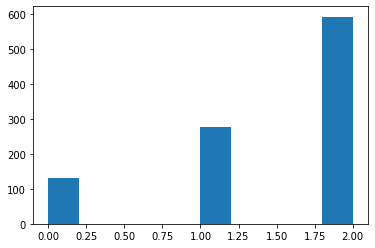

In [19]:
plt.hist(np.array(twoF1StepNEmissions0))
plt.show()

**1 fermion, 2 steps, with coupling**

In [31]:
n_i, N = 1, 2
g_1, g_2, g_12 = 2, 1, 1
eps = .001

circuit, qubits = createCircuit(n_i, N, eps, g_1, g_2, g_12, [[0, 0, 1]])

circuit.append(cirq.measure(*reverse(qubits['pReg'][0]), key='p0'))
circuit.append(cirq.measure(*reverse(qubits['pReg'][1]), key='p1'))
circuit.append(cirq.measure(*reverse(qubits['pReg'][2]), key='p2'))
circuit.append(cirq.measure(*reverse(qubits['hReg'][0]), key='h0'))
circuit.append(cirq.measure(*reverse(qubits['hReg'][1]), key='h1'))
circuit.append(cirq.measure(*reverse(qubits['w_hReg']), key='w_h'))
circuit.append(cirq.measure(*reverse(qubits['eReg']), key='e'))
circuit.append(cirq.measure(*reverse(qubits['wReg']), key='w'))
circuit.append(cirq.measure(*reverse(qubits['n_aReg']), key='n_a'))
circuit.append(cirq.measure(*reverse(qubits['n_bReg']), key='n_b'))
circuit.append(cirq.measure(*reverse(qubits['n_phiReg']), key='n_phi'))
circuit.append(cirq.measure(*reverse(qubits['w_aReg']), key='w_a'))
circuit.append(cirq.measure(*reverse(qubits['w_bReg']), key='w_b'))
circuit.append(cirq.measure(*reverse(qubits['w_phiReg']), key='w_phi'))

simulator = cirq.Simulator()
result1 = simulator.run(circuit, repetitions=1000)

generated circuit on 29 qubits


KeyboardInterrupt: ignored

In [47]:
len(list(circuit.all_operations()))

2190

In [21]:
twoF1StepParticles1 = [result1.measurements['p0'], result1.measurements['p1'], result1.measurements['p2']]
twoF1StepEvents1, twoF1StepNEmissions1, twoF1StepLogThetaMax1 = generateStats(twoF1StepParticles1, 1000, n_i = 1)
print(twoF1StepEvents1)
print(twoF1StepNEmissions1)
print(twoF1StepLogThetaMax1)

[['f1', 'phi', 'phi'], ['f1', None, None], ['f2', None, None], ['f1', 'af1', 'f1'], ['f1', 'af1', 'f1'], ['f2', 'f1', 'af1'], ['f1', 'af1', 'f1'], ['f1', 'phi', 'phi'], ['f1', None, None], ['f1', None, 'phi'], ['f1', 'f1', 'af2'], ['f1', 'f1', 'af1'], ['f2', 'phi', 'phi'], ['f2', None, None], ['f1', None, None], ['f1', 'af1', 'f1'], ['f1', 'phi', 'phi'], ['f1', None, 'phi'], ['f1', None, None], ['f2', None, None], ['f1', 'f1', 'af2'], ['f1', None, 'phi'], ['f2', 'phi', 'phi'], ['f1', None, None], ['f1', 'af1', 'f2'], ['f1', 'f1', 'af2'], ['f2', None, None], ['f1', None, None], ['f1', None, None], ['f1', 'af1', 'f1'], ['f1', 'phi', 'phi'], ['f1', None, 'phi'], ['f1', None, 'phi'], ['f2', None, None], ['f2', 'phi', 'phi'], ['f1', 'phi', 'phi'], ['f1', None, None], ['f1', 'phi', 'phi'], ['f2', 'phi', 'phi'], ['f2', None, None], ['f1', 'phi', 'phi'], ['f2', 'phi', 'phi'], ['f2', None, None], ['f1', 'phi', 'phi'], ['f1', None, 'phi'], ['f1', None, None], ['f1', 'f1', 'af2'], ['f2', 'af1', '

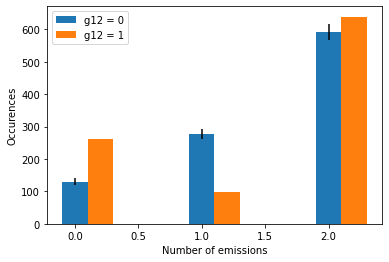

In [25]:
numEmissionsList = [0,1,2]

noCoupleCounts = [np.sum(np.array(twoF1StepNEmissions0)==0), np.sum(np.array(twoF1StepNEmissions0)==1),
                  np.sum(np.array(twoF1StepNEmissions0)==2)]

coupleCounts = [np.sum(np.array(twoF1StepNEmissions1)==0), np.sum(np.array(twoF1StepNEmissions1)==1),
                  np.sum(np.array(twoF1StepNEmissions1)==2)]

barWidth = 0.2
r1 = np.arange(3)
r2 = [x + barWidth for x in r1]

plt.bar(r1, noCoupleCounts, yerr = np.sqrt(noCoupleCounts), width = barWidth, label = "g12 = 0")
plt.bar(r2, coupleCounts, width = barWidth, label = "g12 = 1")
plt.legend()
plt.xlabel("Number of emissions")
plt.ylabel("Occurences")
plt.show()

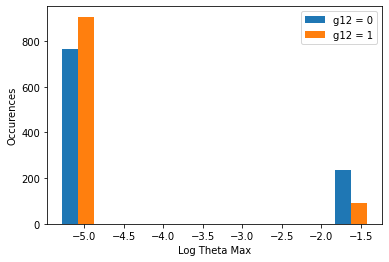

In [29]:
thetaDict0 = {x : twoF1StepLogThetaMax0.count(x) for x in twoF1StepLogThetaMax0}
thetaDict1 = {x : twoF1StepLogThetaMax1.count(x) for x in twoF1StepLogThetaMax1}

barWidth = .2
r1 = list(thetaDict0.keys())
r2 = [x + barWidth for x in r1]

plt.bar(r1, list(thetaDict0.values()), width = barWidth, label = "g12 = 0")
plt.bar(r2, list(thetaDict1.values()), width = barWidth, label = "g12 = 1")
plt.legend()
plt.xlabel("Log Theta Max")
plt.ylabel("Occurences")
plt.show()

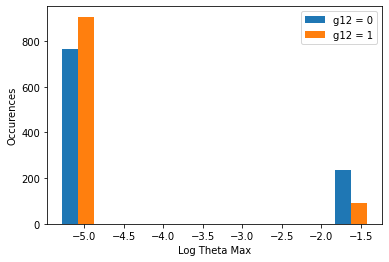

In [30]:
thetaDict0 = {x : twoF1StepLogThetaMax0.count(x) for x in twoF1StepLogThetaMax0}
thetaDict1 = {x : twoF1StepLogThetaMax1.count(x) for x in twoF1StepLogThetaMax1}

barWidth = .2
r1 = list(thetaDict0.keys())
r2 = [x + barWidth for x in r1]

plt.bar(r1, list(thetaDict0.values()), width = barWidth, label = "g12 = 0")
plt.bar(r2, list(thetaDict1.values()), width = barWidth, label = "g12 = 1")
plt.legend()
plt.xlabel("Log Theta Max")
plt.ylabel("Occurences")
plt.show()

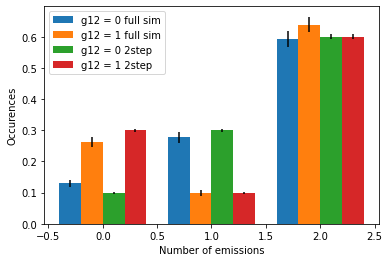

In [27]:
## Saved data from run on 5/21/2020

numEmissionsList = np.array([0,1,2])

noCoupleCounts = np.array(noCoupleCounts)
coupleCounts = np.array(coupleCounts)


benNoCoupleCounts = np.array([.1,.3,.6]) * 10000
benCoupleCounts = np.array([.3, .1, .6]) * 10000

barWidth = 0.2
r1 = np.arange(3)-.3
r2 = [x + barWidth for x in r1]
r3 = [x + 2 * barWidth for x in r1]
r4 = [x + 3 * barWidth for x in r1]

plt.bar(r1, noCoupleCounts/1000, yerr = np.sqrt(noCoupleCounts)/1000, width = barWidth, label = "g12 = 0 full sim")
plt.bar(r2, coupleCounts/1000, width = barWidth, yerr = np.sqrt(coupleCounts)/1000, label = "g12 = 1 full sim")
plt.bar(r3, benNoCoupleCounts/10000, yerr = np.sqrt(benNoCoupleCounts)/10000, width = barWidth, label = "g12 = 0 2step")
plt.bar(r4, benCoupleCounts/10000, width = barWidth, yerr = np.sqrt(benCoupleCounts)/10000, label = "g12 = 1 2step")


plt.legend()
plt.xlabel("Number of emissions")
plt.ylabel("Occurences")
plt.show()

In [0]:
np.sqrt(325)

18.027756377319946

In [27]:
import math
import numpy as np

def Nemissions(myevent,n_I=1):
  #This function returns the observable shown in Fig. 1b.
  mycount = 0
  for i in range(n_I,len(myevent)):
    if myevent[i]!='none':
      mycount+=1
  return mycount

def LogThetaMax(myevent,n_I=1,eps=0.001): 
  #This function returns the observable shown in Fig. 1a.

  N = len(myevent)-n_I
  firstemmit = 0
  for i in range(n_I,len(myevent)):
    if myevent[i]!='none':
      firstemmit = i-n_I
      print(firstemmit)
      break
  
  hist_bins = [math.log(eps**(j / N)) for j in range(N, -1, -1)]
  hist_bins = np.array(hist_bins)
  centers = (hist_bins[:-1] + hist_bins[1:]) / 2
  return centers[firstemmit]

#Let's run some tests
myevent = ['f_1','none','phi']
n_I = 1
print(myevent)
print("log(theta_max):",LogThetaMax(myevent,n_I)) #<-- should be the bin center for the second bin in Fig. 1a
print()

myevent = ['f_1','phi','none']
n_I = 1
print(myevent)
print("log(theta_max):",LogThetaMax(myevent,n_I)) #<-- should be the bin center for the first bin in Fig. 1a
print()

myevent = ['f_1','phi','phi']
print(myevent)
n_I = 1
print("log(theta_max):",LogThetaMax(myevent,n_I)) #<-- should be the bin center for the first bin in Fig. 1a
print()

myevent = ['f_1','none','phi','none']
print(myevent)
n_I = 1
print("log(theta_max):",LogThetaMax(myevent,n_I))
print()

myevent = ['f1', 'af1', 'f1']
print(myevent)
n_I = 1
print("log(theta_max):",LogThetaMax(myevent,n_I))
print()

myevent = ['f1', 'none', 'none']
print(myevent)
n_I = 1
print("log(theta_max):",LogThetaMax(myevent,n_I))

['f_1', 'none', 'phi']
1
log(theta_max): -1.7269388197455342

['f_1', 'phi', 'none']
0
log(theta_max): -5.180816459236603

['f_1', 'phi', 'phi']
0
log(theta_max): -5.180816459236603

['f_1', 'none', 'phi', 'none']
1
log(theta_max): -3.4538776394910684

['f1', 'af1', 'f1']
0
log(theta_max): -5.180816459236603

['f1', 'none', 'none']
log(theta_max): -5.180816459236603
